In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "csvs/analysis_random_v3.csv"
df = pd.read_csv(filepath, sep=";")

df_filtered = df[df["numbers_of_steps_to_solve"] != -1]


C:\Users\adria\AppData\Local\Temp\ipykernel_24992\1157910642.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Valid/total ratio

In [2]:
ratio = len(df_filtered) / len(df)
print(f"{ratio * 100:.2f}%")


61.34%


## Multiple regression analysis

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump


x = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']]
y = df_filtered["numbers_of_steps_to_solve"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

dump(model, "sudoku_model.joblib")

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

print("Coefficients:", model.coef_)


Mean Squared Error: 0.10959950501424874
Coefficient of Determination (R^2): 0.9993135034919762
Coefficients: [ 0.00153542 -0.9946019  -1.51965711]


## Combining columns

In [4]:
df_filtered['entropy_and_coverage_01'] = df_filtered['initial_numbers_entropy'] + 0.1 * df_filtered["number_of_initial_values"] / 81
df_filtered['entropy_and_coverage_005'] = df_filtered['initial_numbers_entropy'] + 0.05 * df_filtered["number_of_initial_values"] / 81

df_filtered = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy', 'entropy_and_coverage_01', 'entropy_and_coverage_005', 'numbers_of_steps_to_solve']]

C:\Users\adria\AppData\Local\Temp\ipykernel_24992\1016047142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['entropy_and_coverage_01'] = df_filtered['initial_numbers_entropy'] + 0.1 * df_filtered["number_of_initial_values"] / 81
C:\Users\adria\AppData\Local\Temp\ipykernel_24992\1016047142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['entropy_and_coverage_005'] = df_filtered['initial_numbers_entropy'] + 0.05 * df_filtered["number_of_initial_values"] / 81


## Correlation test

In [5]:
correlation_matrix = df_filtered.corr()
correlation_matrix.iloc[-1][:-1]

sum_of_candidates           0.943102
number_of_initial_values   -0.999729
initial_numbers_entropy    -0.765076
entropy_and_coverage_01    -0.893612
entropy_and_coverage_005   -0.846406
Name: numbers_of_steps_to_solve, dtype: float64

## Plots

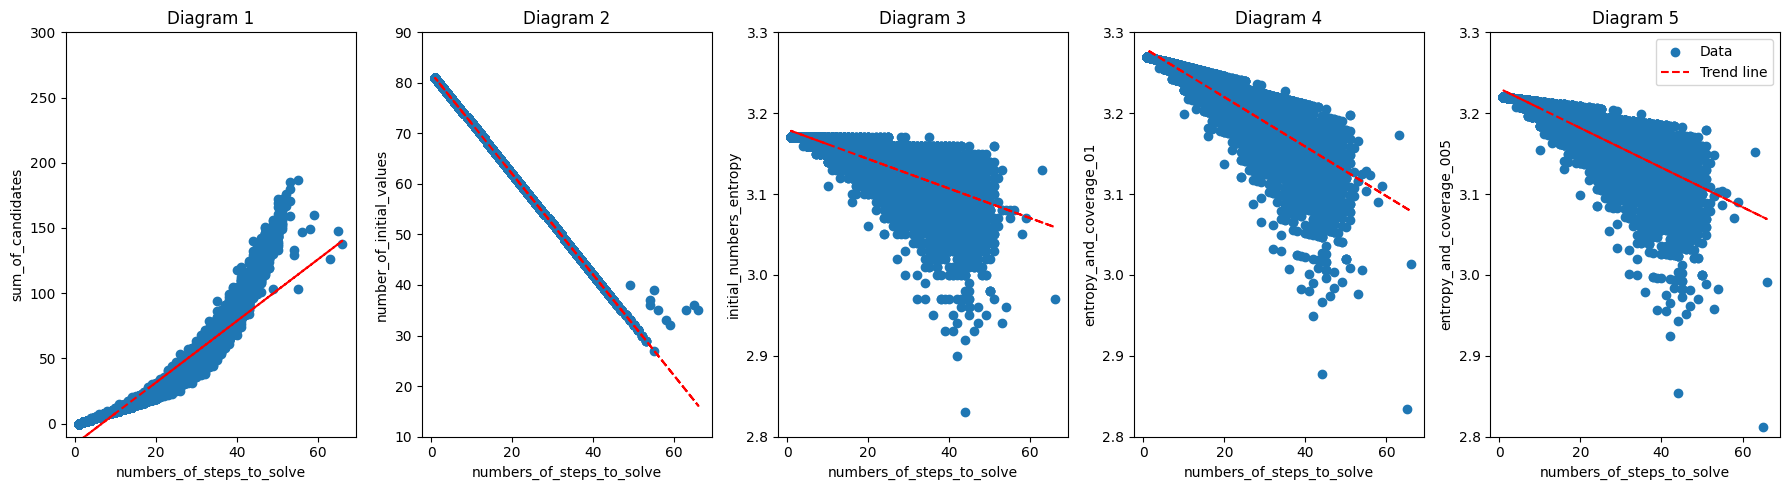

In [6]:
plt.figure(figsize=(18, 5))

# List of column names for plotting
columns = ['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy', 'entropy_and_coverage_01', 'entropy_and_coverage_005']

for i, column in enumerate(columns, 1):
    x = df_filtered['numbers_of_steps_to_solve']
    y = df_filtered[column]
    
    # Scatter plot
    plt.subplot(1, 5, i)
    plt.scatter(x, y, label='Data')
    
    # Fit and plot trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend line')  # "r--" is for red dashed line
    
    plt.title(f'Diagram {i}')
    plt.xlabel('numbers_of_steps_to_solve')
    plt.ylabel(column)
    ax = plt.gca()
    if i == 1:
        ax.set_ylim([-10, 300])
    elif i == 2:
        ax.set_ylim([10, 90])
    else:
        ax.set_ylim([2.8, 3.3])



plt.tight_layout()
plt.legend()
plt.show()

## Other

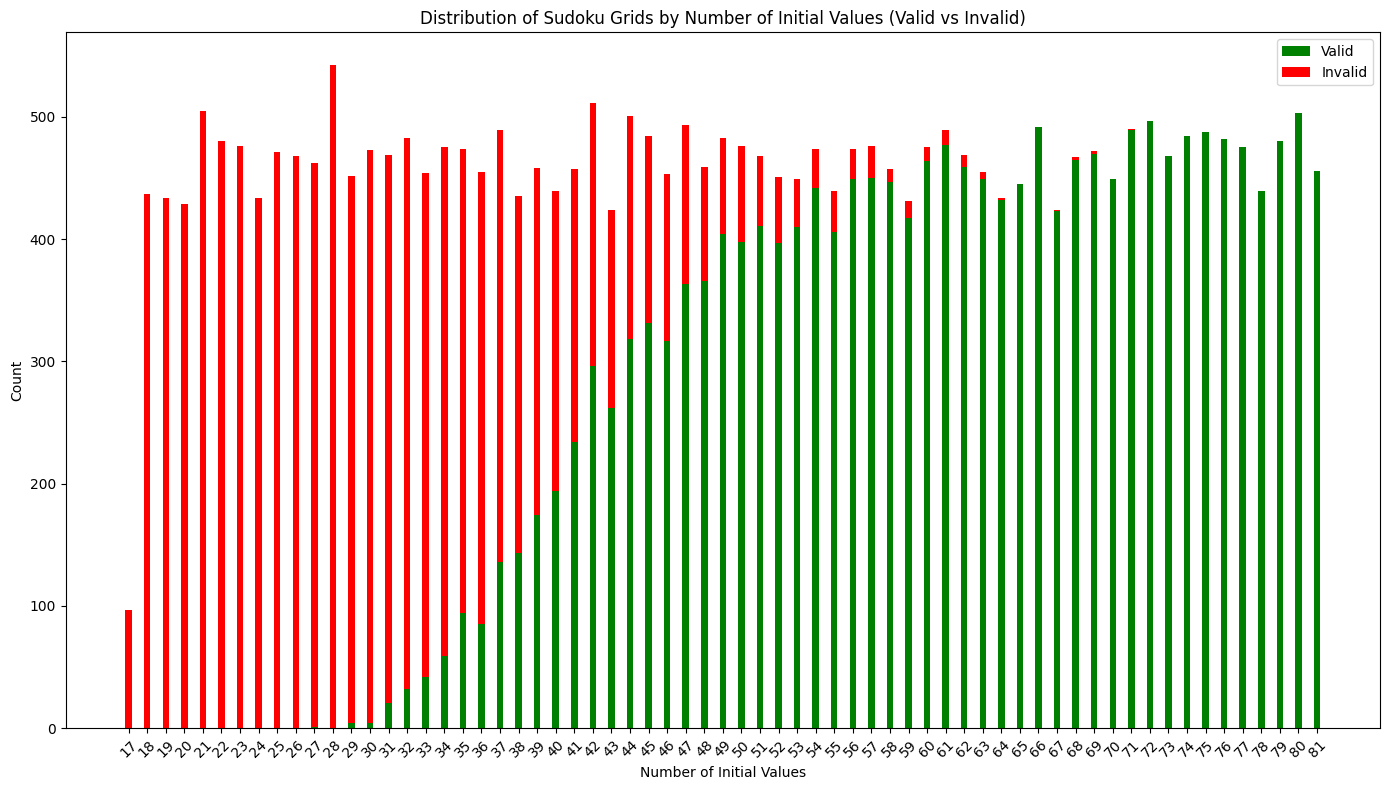

In [7]:
df['is_valid'] = df['numbers_of_steps_to_solve'] != -1

# Group by 'number_of_initial_values' to calculate counts
grouped = df.groupby('number_of_initial_values').agg(
    total_count=('number_of_initial_values', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

# Calculate invalid counts
grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

# Prepare the plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['number_of_initial_values']))

# Plotting the valid and invalid counts as stacked bars
bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Number of Initial Values')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Number of Initial Values (Valid vs Invalid)')
plt.xticks(index, grouped['number_of_initial_values'].astype(str), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

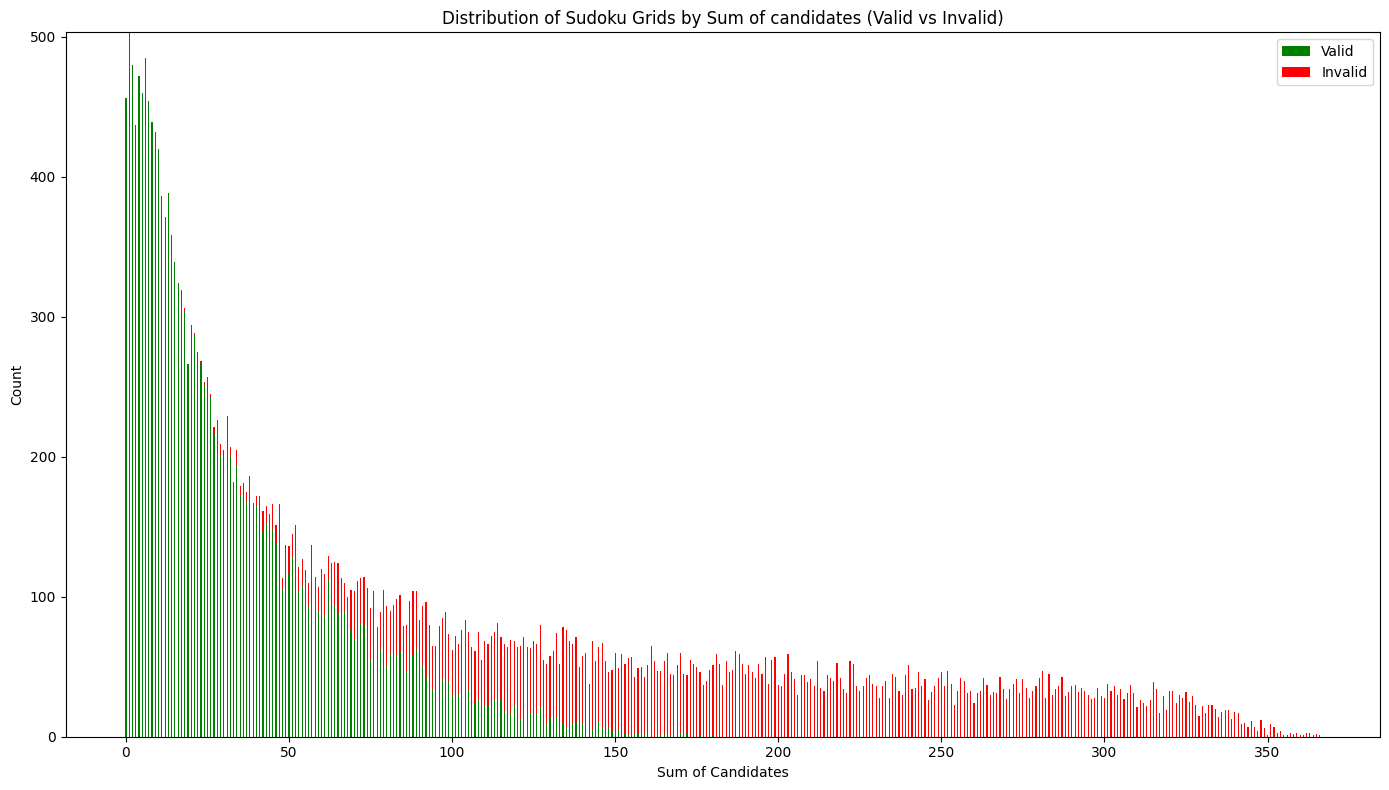

In [8]:
grouped = df.groupby('sum_of_candidates').agg(
    total_count=('sum_of_candidates', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

# Calculate invalid counts
grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

# Prepare the plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['sum_of_candidates']))

# Plotting the valid and invalid counts as stacked bars
bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Sum of Candidates')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Sum of candidates (Valid vs Invalid)')
# plt.xticks(index, grouped['sum_of_candidates'].astype(str), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
df_filtered[df_filtered['number_of_initial_values'] == 81]["numbers_of_steps_to_solve"].max()

for i in range(81, 0, -1):
    tmp = df_filtered[df_filtered['number_of_initial_values'] == i]["numbers_of_steps_to_solve"]
    if  tmp.min() != tmp.max():
        print(i)
        break

40


In [10]:
df_filtered.sort_values("number_of_initial_values")

,sum_of_candidates,number_of_initial_values,initial_numbers_entropy,entropy_and_coverage_01,entropy_and_coverage_005,numbers_of_steps_to_solve
13286,187,27,3.07,3.103333,3.086667,55
9526,180,29,3.08,3.115802,3.097901,53
23221,159,29,3.13,3.165802,3.147901,53
16949,171,29,3.08,3.115802,3.097901,53
25530,185,29,2.94,2.975802,2.957901,53
...,...,...,...,...,...,...
24066,0,81,3.17,3.270000,3.220000,1
24070,0,81,3.17,3.270000,3.220000,1
27212,0,81,3.17,3.270000,3.220000,1
17134,0,81,3.17,3.270000,3.220000,1


In [11]:
grids = df[(df['number_of_initial_values'] == 34) & (df['is_valid'])]['sudoku']

In [20]:
sudokus = df[(df['number_of_initial_values'] == 29) & (df['is_valid'])]['sudoku']

In [21]:
from itertools import combinations
from random import sample

def generate_subsets(grid, n, limit):
    # Find all the indices of non-zero characters in the string
    non_zero_indices = [i for i, char in enumerate(grid) if char != '0']
    
    # Generate all possible combinations of indices to remove n non-zeros, capped by the limit
    # Using sample to randomly select combinations if there are more than the limit
    indices_to_remove_combinations = list(combinations(non_zero_indices, n))
    if len(indices_to_remove_combinations) > limit:
        indices_to_remove_combinations = sample(indices_to_remove_combinations, limit)
    
    subsets = []
    for indices in indices_to_remove_combinations:
        subset_list = list(grid)  # Convert the string to a list for easier manipulation
        # Set the selected non-zero positions to zero
        for index in indices:
            subset_list[index] = '0'
        subsets.append("".join(subset_list))  # Re-convert the list back to a string
    
    return subsets

In [22]:
s21 = []

for s in sudokus:
    subsets = generate_subsets(s, 8, 150000)
    s21.extend(subsets)



In [26]:
with open("grids/grids_random_21.txt", 'w') as f:
    for s in s21:
        f.write(f"{s}\n")